In [1]:
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/train.csv


Redirecting output to ‘wget-log’.


In [2]:
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/test.csv


Redirecting output to ‘wget-log.1’.


In [3]:
!ls

sample_data  test.csv  train.csv  wget-log  wget-log.1


In [4]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [5]:
## Plotly
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

In [0]:
# Others
import nltk
import string
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

In [0]:
#read the file
data = pd.read_csv('train.csv', header='infer')

In [9]:
## check the shape
data.shape

(45825, 3)

In [10]:
#check the first 2 rows
data.head(2)

,ID,categories,converse
0,2,ASK_A_DOCTOR,mom wants to know if the drugname needs some d...
1,3,ASK_A_DOCTOR,patients to discuss drugname she says she has ...


In [12]:
## check the distribution of the target
data['categories'].value_counts()

PRESCRIPTION     12077
APPOINTMENTS     11098
MISCELLANEOUS     9736
ASK_A_DOCTOR      9440
LAB               3457
JUNK                17
Name: categories, dtype: int64

PRESCRIPTION     12077
APPOINTMENTS     11098
MISCELLANEOUS     9736
ASK_A_DOCTOR      9440
LAB               3457
JUNK                17
Name: categories, dtype: int64


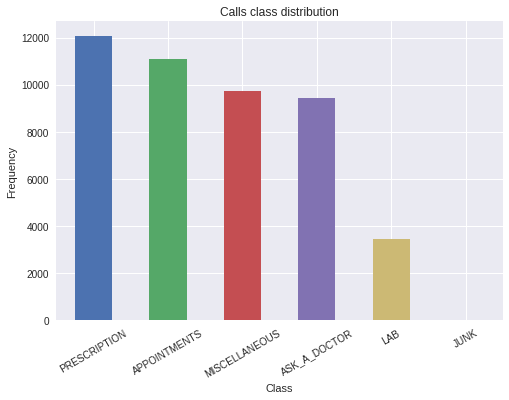

In [16]:
#PLotting the frequencies of fraud and non-fraud transactions in the data
LABELS = ["PRESCRIPTION", "APPOINTMENTS","MISCELLANEOUS","ASK_A_DOCTOR","LAB","JUNK"]
count_classes = pd.value_counts(data['categories'], sort = True)
print(count_classes)

#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0)

#Giving titles and labels to the plot
plt.title("Calls class distribution")
plt.xticks(range(6), LABELS, rotation=30)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [103]:
## check null values it has 29 rows which has null values
data.isnull().sum()

ID             0
categories     0
converse      29
dtype: int64

In [0]:
## drop the null values
data = data.fillna('BLANK')

In [14]:
## check the shape
data.shape

(45825, 3)

In [15]:
#check the null values
data.isnull().sum()

ID            0
categories    0
converse      0
dtype: int64

In [0]:
## create a dictionary for the target
target_dict = {'PRESCRIPTION' : 0, 'APPOINTMENTS' : 1, 'MISCELLANEOUS' : 2, 'ASK_A_DOCTOR' : 3 , 'LAB' : 4, 'JUNK' : 5}

In [0]:
## replace the dictionary values
data['categories'] = [target_dict[i] for i in data['categories']]

In [107]:
## verify 
data.head(5)

,ID,categories,converse
0,2,3,mom wants to know if the drugname needs some d...
1,3,3,patients to discuss drugname she says she has ...
2,5,2,letter of patient establishment request name s...
3,6,1,appointment question name mom appointments pat...
4,8,2,please refax neurocog order to new wake medici...


In [0]:
## find the length of each conversation
data['length'] = 0
i = 0
nrows = data.shape[0]

for i in range(0,nrows):
  x=len(data.iloc[i,2])
  data.iloc[i,3]=x


In [50]:
## check if the converse text is 0 for any rows
data[data['length'] == 0]

,ID,categories,converse,length


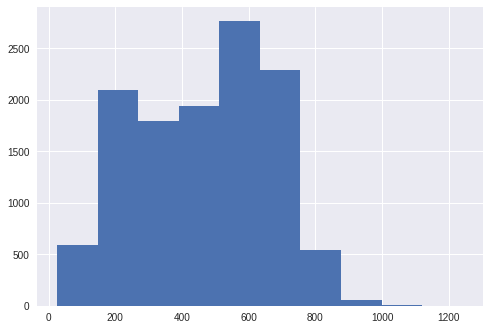

In [51]:
#plot histogram for each category against the length of the converse 
plt.hist(data[data['categories'] == 0]['length'])
mean_target0 = round(data[data['categories'] == 0]['length'].mean(),0)

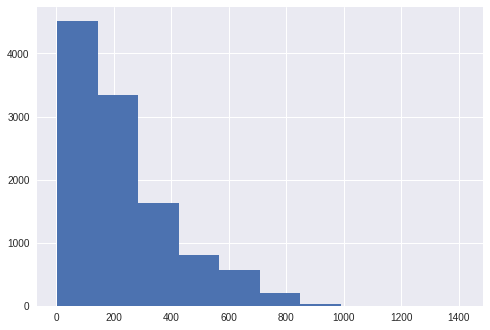

In [52]:
plt.hist(data[data['categories'] == 1]['length'])
mean_target1 = round(data[data['categories'] == 1]['length'].mean(),0)

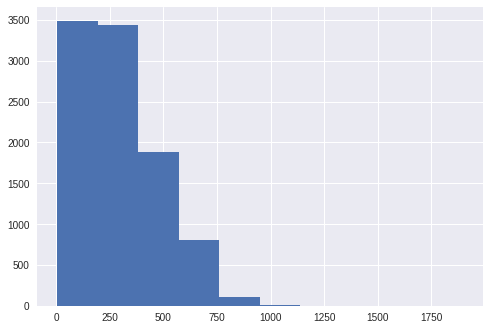

In [53]:
plt.hist(data[data['categories'] == 2]['length'])
mean_target2 = round(data[data['categories'] == 2]['length'].mean(),0)

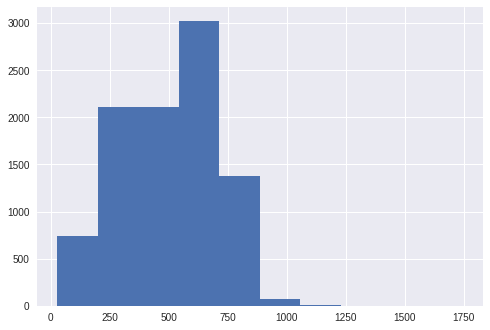

In [54]:
plt.hist(data[data['categories'] == 3]['length'])
mean_target3 = round(data[data['categories'] == 3]['length'].mean(),0)

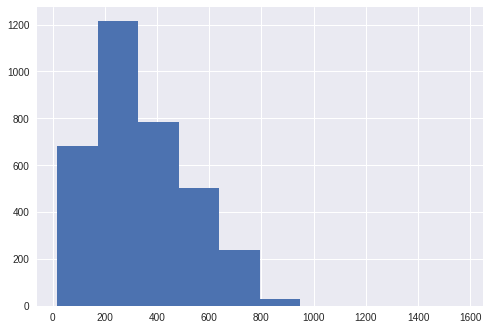

In [55]:
plt.hist(data[data['categories'] == 4]['length'])
mean_target4 = round(data[data['categories'] == 4]['length'].mean(),0)

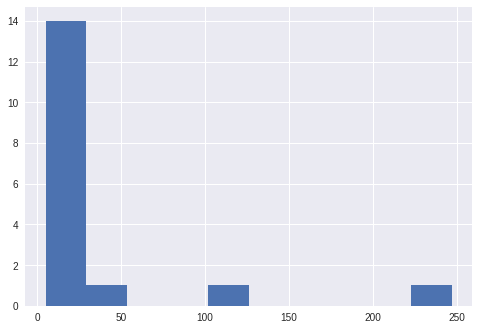

In [56]:
plt.hist(data[data['categories'] == 5]['length'])
mean_target5 = round(data[data['categories'] == 5]['length'].mean(),0)

In [57]:
## check the mean of each class
print(mean_target0, mean_target1, mean_target2, mean_target3, mean_target4, mean_target5)

466.0 227.0 296.0 502.0 340.0 30.0


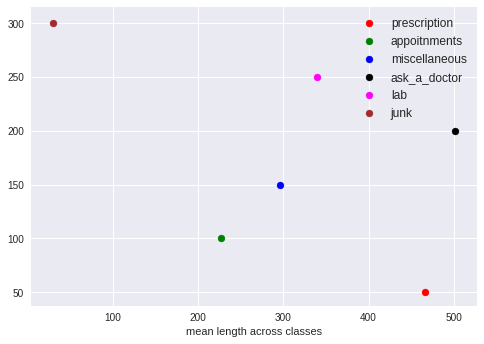

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('mean length across classes')
ax.scatter(466,50,label='prescription',color='red')
ax.scatter(227,100,label='appoitnments',color='green')
ax.scatter(296,150,label='miscellaneous',color='blue')
ax.scatter(502,200,label='ask_a_doctor',color='black')
ax.scatter(340,250,label='lab',color='magenta')
ax.scatter(30,300,label='junk',color='brown')
ax.legend(fontsize='medium')

In [95]:
data.head(5)

,ID,categories,converse,length
0,2,3,mom wants know drugname needs dosage adjusting...,464
1,3,3,patients discuss drugname says weird tas patie...,350
2,5,2,letter patient establishment request name spou...,747
3,6,1,appointment question name mom appointments pat...,628
4,8,2,please refax neurocog order new wake medicines...,302


In [96]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import re

In [0]:
## write a function to clean the text and remove stop words
def CleanText(text):
   # Convert words to lower case and split them
    text = text.lower().split()

    #remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

In [0]:
## now apply the same function on the converse column
data['converse'] = data['converse'].map(lambda x: CleanText(x))

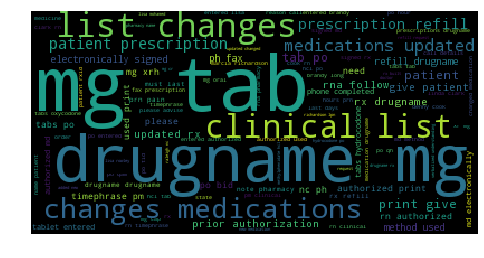

In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


data_prescription = pd.DataFrame(data[data['categories'] == 'PRESCRIPTION'])
word_cloud_text = "";

for i in range(0,1000):
  word_cloud_text = word_cloud_text + data_prescription.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

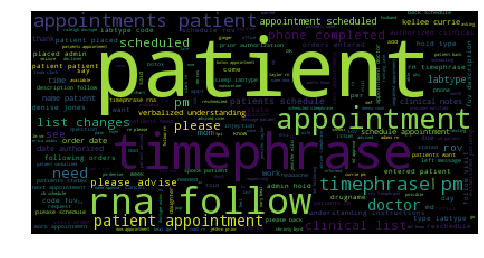

In [40]:
data_appo = pd.DataFrame(data[data['categories'] == 'APPOINTMENTS'])
word_cloud_text = "";

for i in range(0,1000):
  word_cloud_text = word_cloud_text + data_appo.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

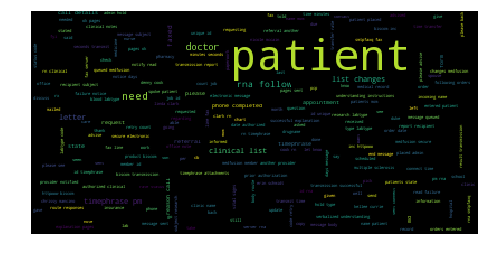

In [41]:
data_misc = pd.DataFrame(data[data['categories'] == 'MISCELLANEOUS'])
word_cloud_text = "";

for i in range(0,1000):
  word_cloud_text = word_cloud_text + data_misc.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

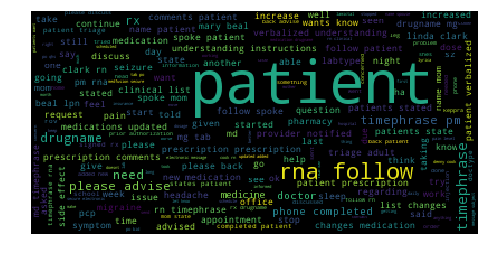

In [42]:
data_askdoc = pd.DataFrame(data[data['categories'] == 'ASK_A_DOCTOR'])
word_cloud_text = "";

for i in range(0,1000):
  word_cloud_text = word_cloud_text + data_askdoc.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

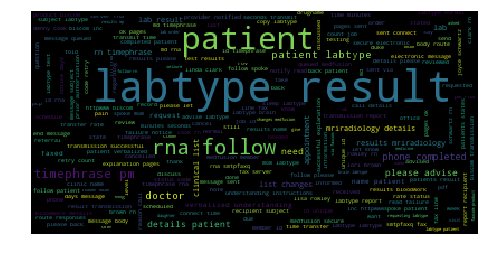

In [43]:
data_lab = pd.DataFrame(data[data['categories'] == 'LAB'])
word_cloud_text = "";

for i in range(0,1000):
  word_cloud_text = word_cloud_text + data_lab.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

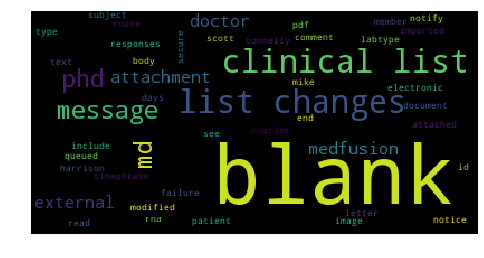

In [45]:
data_junk = pd.DataFrame(data[data['categories'] == 'JUNK'])
word_cloud_text = "";

for i in range(0,17):
  word_cloud_text = word_cloud_text + data_junk.iloc[i,2] + " "
  
 
wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(word_cloud_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [110]:
## verify
print(data.shape)
data.head(4)

(45825, 3)


,ID,categories,converse
0,2,3,mom wants know drugname needs dosage adjusting...
1,3,3,patients discuss drugname says weird tas patie...
2,5,2,letter patient establishment request name spou...
3,6,1,appointment question name mom appointments pat...


In [0]:
data = data.iloc[:,0:3]

In [101]:
data.head(4)

,ID,categories
0,2,3
1,3,3
2,5,2
3,6,1


In [0]:
## initialize some static variables
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4
nb_epochs = 10

In [0]:
from keras.utils import to_categorical

In [114]:
### Create sequence, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['converse'])
sequences = tokenizer.texts_to_sequences(data['converse'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(data['categories']))
print('Shape of data tensor:', data_text.shape)
print('Shape of label tensor:', labels.shape)


Found 34632 unique tokens.
Shape of data tensor: (45825, 100)
Shape of label tensor: (45825, 6)


In [115]:
!wget https://s3.amazonaws.com/audiosampleyug/glove.6B.100d.txt


Redirecting output to ‘wget-log.2’.


In [0]:
!ls

glove.6B.100d.txt  sample_data	test.csv  train.csv


In [0]:
import os

In [118]:
## get the word embeddings from GloVe
embeddings_index = {}
file = open(os.path.join('./', 'glove.6B.100d.txt'))
for line in file:
    values = line.split()
    word = values[0]
    weights = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = weights
file.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_text, labels, test_size=0.001, random_state=1234, stratify=data['categories'])

In [120]:
labels

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
## try using GloVe word embedding with CuDNNGRU
#load pre-trained weights from GloVe and set the trainable as False
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [148]:
print('Training model.')

from keras.layers import LSTM, Dropout
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
z = CuDNNGRU(100)(embedded_sequences)
#layer1 = Dense(16, activation='sigmoid')(z)
preds_lstm = Dense(6, activation='softmax')(z)


from keras.optimizers import Adam
adam = Adam(lr=0.001)
model_lstm = Model(sequence_input, preds_lstm)
model_lstm.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model_lstm_hist = model_lstm.fit(x_train, y_train,
                  batch_size=20,
                  epochs=10,
                  validation_split=0.4).history

Training model.
Train on 27467 samples, validate on 18312 samples
Epoch 1/5
27467/27467 [==============================] - 41s 1ms/step - loss: 0.9206 - acc: 0.6707 - val_loss: 0.6696 - val_acc: 0.7779
Epoch 2/5
27467/27467 [==============================] - 38s 1ms/step - loss: 0.6182 - acc: 0.7894 - val_loss: 0.5855 - val_acc: 0.7919
Epoch 3/5
27467/27467 [==============================] - 39s 1ms/step - loss: 0.5462 - acc: 0.8057 - val_loss: 0.5665 - val_acc: 0.7937
Epoch 4/5
27467/27467 [==============================] - 40s 1ms/step - loss: 0.5033 - acc: 0.8192 - val_loss: 0.5436 - val_acc: 0.8001
Epoch 5/5
27467/27467 [==============================] - 39s 1ms/step - loss: 0.4691 - acc: 0.8287 - val_loss: 0.5414 - val_acc: 0.7997


In [149]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 100)               60600     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
Total params: 2,062,318
Trainable params: 62,318
Non-trainable params: 2,000,000
_________________________________________________________________


In [150]:
# test on test accuracy
loss, acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 78.260869


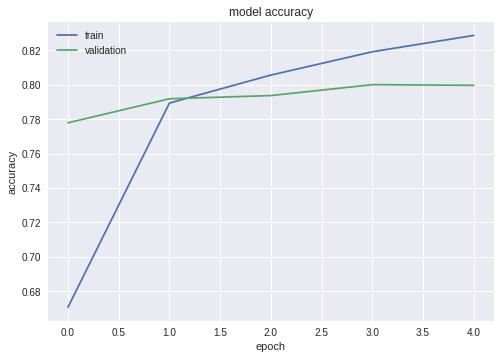

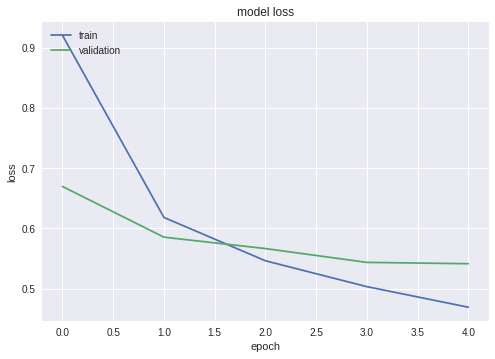

In [185]:
##plot of accuracy and loss for the model
#  "Accuracy"
plt.plot(model_lstm_hist['acc'])
plt.plot(model_lstm_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_lstm_hist['loss'])
plt.plot(model_lstm_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
test_data = pd.read_csv('test.csv', header='infer')

In [129]:
test_data.head(2)

,ID,converse
0,1,patients aware that he needs rov for refill na...
1,4,fyi nortryptline medication patient prescripti...


In [152]:
test_data.isnull().sum()

ID          0
converse    7
dtype: int64

In [0]:
## fill the null values with some value
test_data = test_data.fillna('BLANK')

In [154]:
test_data.isnull().sum()

ID          0
converse    0
dtype: int64

In [155]:
test_data.shape

(11455, 2)

In [156]:
### Create sequence, vectorize the text samples into a 2D integer tensor
tokenizer_test = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_test.fit_on_texts(test_data['converse'])
sequences_test = tokenizer.texts_to_sequences(test_data['converse'])

word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index_test))

data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

Found 16643 unique tokens.


In [157]:
data_test.shape

(11455, 100)

In [0]:
## predict on test data
test_probs = model_lstm.predict(data_test, verbose=0)
test_classes = test_probs.argmax(axis=-1)

In [0]:
## create a dictionary for the test
test_dict = { 0 : 'PRESCRIPTION', 1 : 'APPOINTMENTS', 2 : 'MISCELLANEOUS', 3 : 'ASK_A_DOCTOR' , 4 : 'LAB', 5 : 'JUNK'}
## replace the dictionary values
preds_GloVe_final = [test_dict[i] for i in test_classes]

In [159]:
np.unique(preds_GloVe_final)

array(['APPOINTMENTS', 'ASK_A_DOCTOR', 'JUNK', 'LAB', 'MISCELLANEOUS',
       'PRESCRIPTION'], dtype='<U13')

In [0]:
## convert into class labels from the dictionary
final_pred_df = pd.DataFrame(
    {'categories': preds_GloVe_final })
final_pred = pd.concat([test_data['ID'],final_pred_df], axis=1)
## write to a file
final_pred.to_csv('PC_submission_GloVe_2.csv', index=False)

In [0]:
## try with CNN and GloVe word embedding
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Conv1D(64, 5, activation='relu')(x)
#x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

model_CNN = Model(sequence_input, preds)
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [182]:
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               311424    
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 774       
Total para

In [183]:
model_CNN_hist = model_CNN.fit(x_train, y_train, validation_split=0.4,
          epochs=10, batch_size=20).history

Train on 27467 samples, validate on 18312 samples
Epoch 1/10
27467/27467 [==============================] - 14s 518us/step - loss: 0.7790 - acc: 0.7228 - val_loss: 0.6968 - val_acc: 0.7625
Epoch 2/10
27467/27467 [==============================] - 13s 491us/step - loss: 0.5946 - acc: 0.7930 - val_loss: 0.6690 - val_acc: 0.7558
Epoch 3/10
27467/27467 [==============================] - 14s 493us/step - loss: 0.5127 - acc: 0.8250 - val_loss: 0.7082 - val_acc: 0.7647
Epoch 4/10
27467/27467 [==============================] - 14s 494us/step - loss: 0.4332 - acc: 0.8496 - val_loss: 0.8161 - val_acc: 0.7642
Epoch 5/10
27467/27467 [==============================] - 14s 495us/step - loss: 0.3679 - acc: 0.8735 - val_loss: 0.9452 - val_acc: 0.7674
Epoch 6/10
27467/27467 [==============================] - 14s 494us/step - loss: 0.3051 - acc: 0.8974 - val_loss: 1.0886 - val_acc: 0.7570
Epoch 7/10
27467/27467 [==============================] - 14s 493us/step - loss: 0.2601 - acc: 0.9139 - val_loss: 1.

In [184]:
# test on test accuracy
loss, acc = model_CNN.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 76.086956


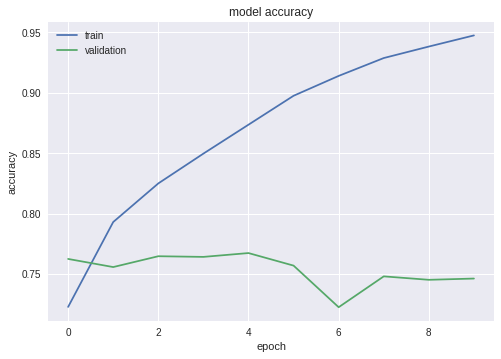

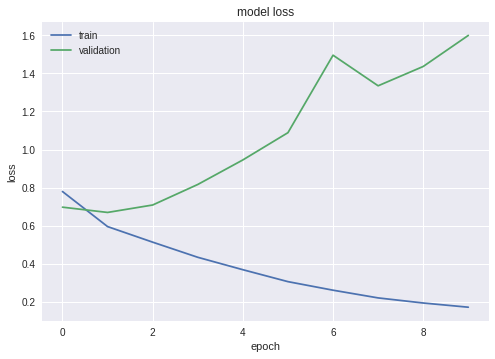

In [186]:
##plot of accuracy and loss for the model
#  "Accuracy"
plt.plot(model_CNN_hist['acc'])
plt.plot(model_CNN_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_CNN_hist['loss'])
plt.plot(model_CNN_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
##create a text_to_maxtrix and try MLP with 8000 words
train = pd.read_csv('train.csv', header='infer')
test = pd.read_csv('test.csv', header='infer')
data = pd.DataFrame(pd.concat([train['converse'], test['converse']], axis = 0))
data.columns = ['converse']
data_new = data.fillna('BLANK')
data_new['converse'] = data_new['converse'].map(lambda x: CleanText(x))

In [0]:
## initialize some static variables
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 8000

In [189]:
### Create sequence, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_new['converse'])
encoded_docs = tokenizer.texts_to_matrix(data_new['converse'], mode='freq')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_new_text = encoded_docs

Found 39151 unique tokens.


In [0]:
## now split the train and test again as per original files
train_data = data_new_text[:45825,]
test_data = data_new_text[45825:,]
## replace the dictionary values
train['categories'] = [target_dict[i] for i in train['categories']]
labels = to_categorical(np.asarray(train['categories']))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.001, random_state=1234, stratify = train['categories'])

In [0]:
model_MLP = Sequential()
model_MLP.add(Dense(units=16, input_dim=8000, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(32, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(16, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(units=6, activation='softmax'))

In [213]:
#check the summary
model_MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                128016    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 102       
Total para

In [0]:
model_MLP.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [215]:
## print("Training...")
model_mlp_hist = model_MLP.fit(x_train, y_train, epochs=5, batch_size=20, validation_split=0.4 ,verbose=2).history

Train on 27467 samples, validate on 18312 samples
Epoch 1/5
 - 16s - loss: 1.0779 - acc: 0.5752 - val_loss: 0.7218 - val_acc: 0.7369
Epoch 2/5
 - 15s - loss: 0.7568 - acc: 0.7334 - val_loss: 0.6420 - val_acc: 0.7750
Epoch 3/5
 - 15s - loss: 0.6752 - acc: 0.7639 - val_loss: 0.6282 - val_acc: 0.7805
Epoch 4/5
 - 15s - loss: 0.6253 - acc: 0.7808 - val_loss: 0.6154 - val_acc: 0.7848
Epoch 5/5
 - 15s - loss: 0.5824 - acc: 0.8026 - val_loss: 0.6133 - val_acc: 0.7848


In [203]:
## checkinhg accuracy on test prediction
loss, acc = model_MLP.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 80.434783


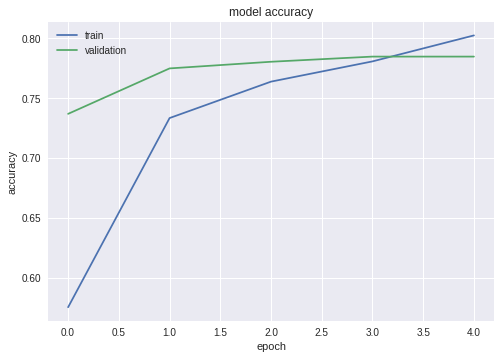

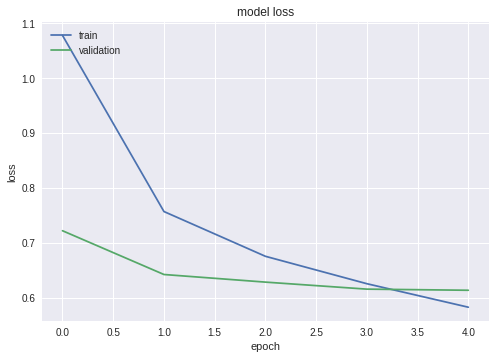

In [216]:
##plot of accuracy and loss for the model
#  "Accuracy"
plt.plot(model_mlp_hist['acc'])
plt.plot(model_mlp_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_mlp_hist['loss'])
plt.plot(model_mlp_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
## predict on test data
test_probs = model_MLP.predict(test_data, verbose=0)
test_classes = test_probs.argmax(axis=-1)

In [208]:
np.unique(test_classes)

array([0, 1, 2, 3, 4])

In [0]:
## create a dictionary for the test
test_dict = { 0 : 'PRESCRIPTION', 1 : 'APPOINTMENTS', 2 : 'MISCELLANEOUS', 3 : 'ASK_A_DOCTOR' , 4 : 'LAB', 5 : 'JUNK'}
## replace the dictionary values
preds_MLP_final = [test_dict[i] for i in test_classes]

In [0]:
## convert into class labels from the dictionary
final_pred_df = pd.DataFrame(
    {'categories': preds_MLP_final })
final_pred = pd.concat([test['ID'],final_pred_df], axis=1)
## write to a file
final_pred.to_csv('PC_submission_MLP_1.csv', index=False)

In [0]:
## try with word embedding and LSTM

In [0]:
## convert this to tokenized words of 100 dimensions
## initialize some static variables
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4
nb_epochs = 10

In [218]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_new['converse'])
sequences = tokenizer.texts_to_sequences(data_new['converse'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_new_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 39151 unique tokens.


In [219]:
## now split the train and test again as per original files
train_data = data_new_text[:45825,]
test_data = data_new_text[45825:,]
labels = to_categorical(np.asarray(train['categories']))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (45825, 100)
Shape of label tensor: (45825, 6)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.001, stratify = train['categories'])

In [0]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_NUM_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))
#model_LSTM.add(LSTM(units=100,dropout = 0.2, recurrent_dropout=0.2))
model_LSTM.add(CuDNNLSTM(units=100))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=6, activation='softmax'))

In [247]:
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 606       
Total params: 2,081,006
Trainable params: 2,081,006
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_LSTM.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [259]:
model_LSTM_hist = model_LSTM.fit(x_train, y_train, epochs=5, validation_split=0.4).history

Train on 27467 samples, validate on 18312 samples
Epoch 1/5
27467/27467 [==============================] - 31s 1ms/step - loss: 0.8580 - acc: 0.6928 - val_loss: 0.6558 - val_acc: 0.7763
Epoch 2/5
27467/27467 [==============================] - 29s 1ms/step - loss: 0.6267 - acc: 0.7838 - val_loss: 0.5763 - val_acc: 0.8005
Epoch 3/5
27467/27467 [==============================] - 29s 1ms/step - loss: 0.5464 - acc: 0.8065 - val_loss: 0.5799 - val_acc: 0.7993
Epoch 4/5
27467/27467 [==============================] - 30s 1ms/step - loss: 0.5060 - acc: 0.8197 - val_loss: 0.5580 - val_acc: 0.8011
Epoch 5/5
27467/27467 [==============================] - 30s 1ms/step - loss: 0.4747 - acc: 0.8297 - val_loss: 0.5475 - val_acc: 0.8046


In [260]:
## checkinhg accuracy on test prediction
loss, acc = model_LSTM.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 80.434782


In [0]:
preds_LSTM_test = model_LSTM.predict_classes(test_data, verbose=0)
## replace the dictionary values
preds_LSTM_final = [test_dict[i] for i in preds_LSTM_test]

In [262]:
np.unique(preds_LSTM_final)

array(['APPOINTMENTS', 'ASK_A_DOCTOR', 'JUNK', 'LAB', 'MISCELLANEOUS',
       'PRESCRIPTION'], dtype='<U13')

In [0]:
## create a dataframe
final_pred_df = pd.DataFrame(
    {'categories': preds_LSTM_final })
final_pred = pd.concat([test['ID'],final_pred_df], axis=1)
## write to a file
final_pred.to_csv('PC_submission_LSTM_2.csv', index=False)

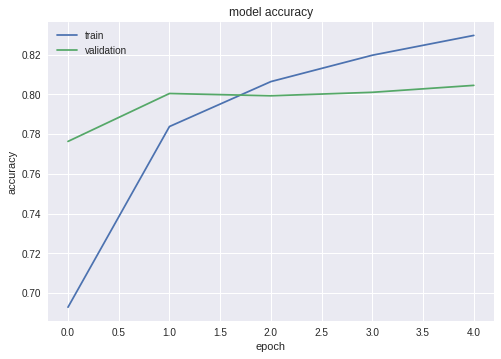

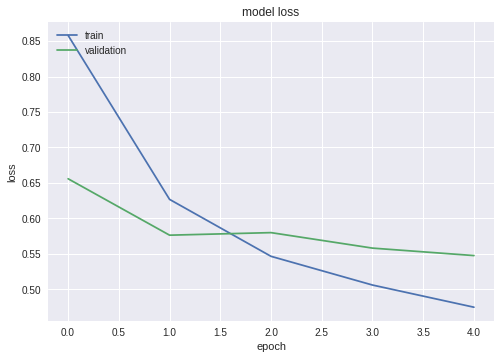

In [264]:
##plot of accuracy and loss for the model
#  "Accuracy"
plt.plot(model_LSTM_hist['acc'])
plt.plot(model_LSTM_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_LSTM_hist['loss'])
plt.plot(model_LSTM_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model_GRU_WE = Sequential()
model_GRU_WE.add(Embedding(20000,
                    100,
                    input_length=100))
model_GRU_WE.add(CuDNNGRU(units=100))
model_GRU_WE.add(Dropout(0.2))
model_GRU_WE.add(Dense(units=6, activation='softmax'))

In [266]:
model_GRU_WE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 100)               60600     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 606       
Total params: 2,061,206
Trainable params: 2,061,206
Non-trainable params: 0
_________________________________________________________________


In [269]:
model_GRU_WE.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_GRU_WE_hist = model_GRU_WE.fit(x_train, y_train, epochs=3, validation_split=0.4).history

Train on 27467 samples, validate on 18312 samples
Epoch 1/3
27467/27467 [==============================] - 29s 1ms/step - loss: 0.8409 - acc: 0.6839 - val_loss: 0.5941 - val_acc: 0.7935
Epoch 2/3
27467/27467 [==============================] - 27s 976us/step - loss: 0.5402 - acc: 0.8042 - val_loss: 0.5361 - val_acc: 0.8073
Epoch 3/3
27467/27467 [==============================] - 27s 969us/step - loss: 0.4873 - acc: 0.8212 - val_loss: 0.5087 - val_acc: 0.8158


In [270]:
## checkinhg accuracy on test prediction
loss, acc = model_GRU_WE.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 82.608695


In [0]:
preds_GRU_WE_test = model_GRU_WE.predict_classes(test_data, verbose=0)
## create a dictionary for the test
test_dict = { 0 : 'PRESCRIPTION', 1 : 'APPOINTMENTS', 2 : 'MISCELLANEOUS', 3 : 'ASK_A_DOCTOR' , 4 : 'LAB', 5 : 'JUNK'}
## replace the dictionary values
preds_GRU_WE_final = [test_dict[i] for i in preds_GRU_WE_test]
## convert into class labels from the dictionary
final_pred_df = pd.DataFrame(
    {'categories': preds_GRU_WE_final })
final_pred = pd.concat([test['ID'],final_pred_df], axis=1)
## write to a file
final_pred.to_csv('PC_submission_GRU_2.csv', index=False)

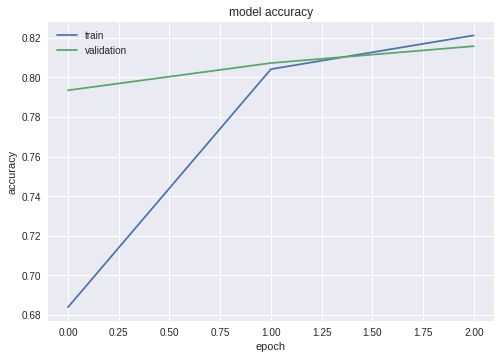

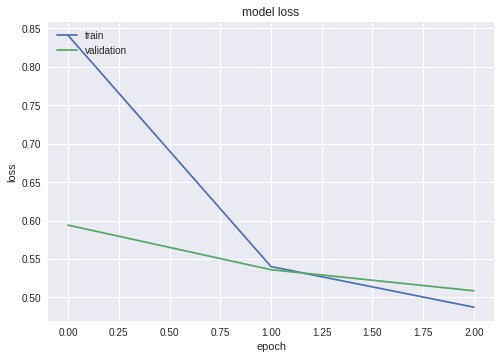

In [272]:
##plot of accuracy and loss for the model
#  "Accuracy"
plt.plot(model_GRU_WE_hist['acc'])
plt.plot(model_GRU_WE_hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_GRU_WE_hist['loss'])
plt.plot(model_GRU_WE_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

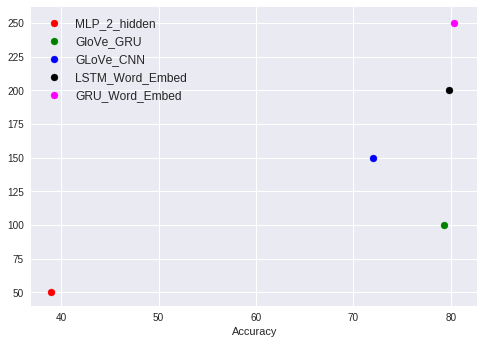

In [273]:
##Model Summary
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('Accuracy')
ax.scatter(39,50,label='MLP_2_hidden',color='red')
ax.scatter(79.3,100,label='GloVe_GRU',color='green')
ax.scatter(72,150,label='GLoVe_CNN',color='blue')
ax.scatter(79.8,200,label='LSTM_Word_Embed',color='black')
ax.scatter(80.3,250,label='GRU_Word_Embed',color='magenta')
ax.legend(fontsize='medium')